# Baseline Model - Linear Regression

This notebook implements a **simple baseline model** using Linear Regression to predict bakery sales.

## Why Linear Regression?
- **Simple & Interpretable**: Easy to understand and explain
- **Fast Training**: Trains in seconds
- **Good Baseline**: Provides reference point for comparison
- **Equation-based**: Can write explicit prediction formula

---
## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)

print("✓ Libraries imported successfully!")
print("\nBaseline Model: Linear Regression")

✓ Libraries imported successfully!

Baseline Model: Linear Regression


---
## 2. Load Data

In [3]:
# Load dataset
df = pd.read_csv('../0_DataPreparation/0.3 Additional Features/complete_dataset_with_additional_features.csv')
df['date'] = pd.to_datetime(df['date'])

print("="*80)
print("DATA LOADED")
print("="*80)
print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")

df.head()

DATA LOADED

Shape: 11,164 rows × 50 columns
Date range: 2013-07-01 to 2019-07-30


,id,date,Warengruppe,umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,Is_Holiday,Day_Before_Holiday,Day_After_Holiday,Is_Vacation,Vacation_Type,day_of_the_week,month,is_weekend,days_to_weekend,bewoelkung_category,wettercode_category,season,temperature_category,temp_change_1d,temp_trend_3d,umsatz_ma7,umsatz_ma14,umsatz_volatility_7d,umsatz_sum_7d,umsatz_lag1,umsatz_lag7,umsatz_pct_change,umsatz_pct_change_lag1,season_numeric,is_weekend_int,weekend_season_interaction,weekend_season_category,holiday_temp_interaction,holiday_temp_category,day_before_holiday_int,day_before_holiday_weekend_interaction,day_before_holiday_weekend_category,KielerWoche_binary,kielerweek_temp_interaction,kielerweek_temp_category,temp_season_interaction,temp_season_category,weekend_temp_interaction,weekend_temp_category,bewoelkung_weekend_interaction,bewoelkung_weekend_category
0,1307011.0,2013-07-01,1.0,148.828353,NaN,6.0,17.8375,15.0,20.0,0,0,0,1,Summer,0,7,False,5,Very cloudy,Drizzle (not freezing) or snow grains,Summer,Medium,NaN,NaN,148.828353,148.828353,NaN,148.828353,NaN,NaN,NaN,NaN,3,0,0,Weekday_Summer,0.0,No_Holiday,0,0,Regular_Day,0,0.0,No_KielerWoche,9.0,Medium_Summer,0.0,Weekday_Medium,0.0,Weekday_Very cloudy
1,1307012.0,2013-07-01,2.0,535.856285,NaN,6.0,17.8375,15.0,20.0,0,0,0,1,Summer,0,7,False,5,Very cloudy,Drizzle (not freezing) or snow grains,Summer,Medium,0.0,NaN,342.342319,342.342319,273.670075,684.684638,148.828353,NaN,2.600499,NaN,3,0,0,Weekday_Summer,0.0,No_Holiday,0,0,Regular_Day,0,0.0,No_KielerWoche,9.0,Medium_Summer,0.0,Weekday_Medium,0.0,Weekday_Very cloudy
2,1307013.0,2013-07-01,3.0,201.198426,NaN,6.0,17.8375,15.0,20.0,0,0,0,1,Summer,0,7,False,5,Very cloudy,Drizzle (not freezing) or snow grains,Summer,Medium,0.0,NaN,295.294355,295.294355,209.971874,885.883064,535.856285,NaN,-0.624529,2.600499,3,0,0,Weekday_Summer,0.0,No_Holiday,0,0,Regular_Day,0,0.0,No_KielerWoche,9.0,Medium_Summer,0.0,Weekday_Medium,0.0,Weekday_Very cloudy
3,1307014.0,2013-07-01,4.0,65.890169,NaN,6.0,17.8375,15.0,20.0,0,0,0,1,Summer,0,7,False,5,Very cloudy,Drizzle (not freezing) or snow grains,Summer,Medium,0.0,0.0,237.943308,237.943308,206.273351,951.773232,201.198426,NaN,-0.672512,-0.624529,3,0,0,Weekday_Summer,0.0,No_Holiday,0,0,Regular_Day,0,0.0,No_KielerWoche,9.0,Medium_Summer,0.0,Weekday_Medium,0.0,Weekday_Very cloudy
4,1307015.0,2013-07-01,5.0,317.475875,NaN,6.0,17.8375,15.0,20.0,0,0,0,1,Summer,0,7,False,5,Very cloudy,Drizzle (not freezing) or snow grains,Summer,Medium,0.0,0.0,253.849821,253.849821,182.144468,1269.249107,65.890169,NaN,3.818259,-0.672512,3,0,0,Weekday_Summer,0.0,No_Holiday,0,0,Regular_Day,0,0.0,No_KielerWoche,9.0,Medium_Summer,0.0,Weekday_Medium,0.0,Weekday_Very cloudy


---
## 3. Data Cleaning

In [4]:
print("Cleaning data...\n")

# Separate data
df_with_sales = df[df['umsatz'].notna()].copy()
df_without_sales = df[df['umsatz'].isna()].copy()

print(f"Training data: {len(df_with_sales):,} rows")
print(f"Test data: {len(df_without_sales):,} rows")

# Drop lag features (prevent data leakage)
lag_cols = [col for col in df.columns if any(x in col.lower() for x in ['lag', '_ma', 'volatility', 'pct_change', 'sum_7d'])]
if 'id' in df.columns:
    lag_cols.append('id')

print(f"\nDropping {len(lag_cols)} lag features to prevent data leakage")

df_with_sales = df_with_sales.drop(columns=lag_cols, errors='ignore')
df_without_sales = df_without_sales.drop(columns=lag_cols, errors='ignore')

# Fill missing values
for col in df_with_sales.columns:
    if df_with_sales[col].isnull().sum() > 0:
        if df_with_sales[col].dtype in ['float64', 'int64']:
            fill_val = df_with_sales[col].median()
            df_with_sales[col].fillna(fill_val, inplace=True)
            df_without_sales[col].fillna(fill_val, inplace=True)
        else:
            fill_val = 'Unknown'
            df_with_sales[col].fillna(fill_val, inplace=True)
            df_without_sales[col].fillna(fill_val, inplace=True)

print(f"✓ Data cleaned!")

Cleaning data...

Training data: 9,334 rows
Test data: 1,830 rows

Dropping 9 lag features to prevent data leakage
✓ Data cleaned!


---
## 4. Split Data

In [5]:
# Split chronologically (time series!)
train_data = df_with_sales[df_with_sales['date'] < '2017-08-01'].copy()
val_data = df_with_sales[df_with_sales['date'] >= '2017-08-01'].copy()
test_data = df_without_sales.copy()

print("Data Split:")
print(f"  Training:   {len(train_data):,} rows | {train_data['date'].min().date()} to {train_data['date'].max().date()}")
print(f"  Validation: {len(val_data):,} rows | {val_data['date'].min().date()} to {val_data['date'].max().date()}")
print(f"  Test:       {len(test_data):,} rows | {test_data['date'].min().date()} to {test_data['date'].max().date()}")

Data Split:
  Training:   7,493 rows | 2013-07-01 to 2017-07-31
  Validation: 1,841 rows | 2017-08-01 to 2018-07-31
  Test:       1,830 rows | 2018-08-01 to 2019-07-30


---
## 5. Prepare Features

In [ ]:
# Exclude non-feature columns
exclude_cols = ['date', 'umsatz']

# Get categorical columns
categorical_cols = train_data.select_dtypes(include=['object', 'bool']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

print(f"Categorical columns: {len(categorical_cols)}")

# One-hot encoding (handles unseen categories)
print(f"\nApplying One-Hot Encoding...")

all_data = pd.concat([train_data, val_data, test_data], ignore_index=True)
all_encoded = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True, dtype=int)

# Split back
train_encoded = all_encoded.iloc[:len(train_data)].copy()
val_encoded = all_encoded.iloc[len(train_data):len(train_data)+len(val_data)].copy()
test_encoded = all_encoded.iloc[len(train_data)+len(val_data):].copy()

# Create feature matrices
feature_cols = [col for col in train_encoded.columns if col not in exclude_cols]

X_train = train_encoded[feature_cols]
X_val = val_encoded[feature_cols]
X_test = test_encoded[feature_cols]

y_train = train_encoded['umsatz']
y_val = val_encoded['umsatz']

print(f"\nFeature matrices created:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"\n✓ Ready for modeling!")

Categorical columns: 13

Applying One-Hot Encoding...

Feature matrices created:
  X_train: (8294, 117)
  X_val:   (1040, 117)
  X_test:  (1830, 117)

✓ Ready for modeling!


---
## 6. Helper Functions

In [ ]:
def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return mape

def adjusted_r2(r2, n_samples, n_features):
    """Calculate Adjusted R²"""
    adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)
    return adj_r2

print("✓ Helper functions ready")

✓ Helper functions ready


---
## 7. Train Linear Regression Model

In [ ]:
print("="*80)
print("TRAINING BASELINE MODEL")
print("="*80)

# Create and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("\n✓ Model trained successfully!")

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

print(f"\nPredictions generated")

TRAINING BASELINE MODEL

✓ Model trained successfully!

Predictions generated


---
## 8. Evaluate Model

In [ ]:
# Calculate metrics
train_mape = calculate_mape(y_train, y_train_pred)
val_mape = calculate_mape(y_val, y_val_pred)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

train_adj_r2 = adjusted_r2(train_r2, len(X_train), X_train.shape[1])
val_adj_r2 = adjusted_r2(val_r2, len(X_val), X_val.shape[1])

train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

# Display results
print("="*80)
print("BASELINE MODEL - EVALUATION RESULTS")
print("="*80)

print(f"\n{'Metric':20s} {'Training':>15s} {'Validation':>15s}")
print("-"*50)
print(f"{'MAPE':20s} {train_mape:14.2f}% {val_mape:14.2f}%")
print(f"{'R²':20s} {train_r2:15.4f} {val_r2:15.4f}")
print(f"{'Adjusted R²':20s} {train_adj_r2:15.4f} {val_adj_r2:15.4f}")
print(f"{'MAE (€)':20s} {train_mae:15.2f} {val_mae:15.2f}")

print(f"\n{'='*80}")

BASELINE MODEL - EVALUATION RESULTS

Metric                      Training      Validation
--------------------------------------------------
MAPE                          79.86%          76.52%
R²                            0.1128          0.1211
Adjusted R²                   0.1001          0.0095
MAE (€)                       108.61          100.18



---
## 9. Model Equation & Feature Importance

In [ ]:
# Model equation
print("Model Equation:")
print(f"  Sales = {lr_model.intercept_:.2f} + Σ(βᵢ × Featureᵢ)")
print(f"\n  Where:")
print(f"    β₀ (intercept) = {lr_model.intercept_:.2f}")
print(f"    Number of features = {len(feature_cols)}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nTop 15 Most Important Features (by absolute coefficient):")
print(feature_importance.head(15).to_string(index=False))

Model Equation:
  Sales = 183.18 + Σ(βᵢ × Featureᵢ)

  Where:
    β₀ (intercept) = 183.18
    Number of features = 117

Top 15 Most Important Features (by absolute coefficient):
                                                        Feature  Coefficient
                                          Vacation_Type_Whitsun    49.659934
                                        Vacation_Type_Christmas    46.043074
        wettercode_category_Heavy continuous fall of snowflakes    42.949236
                                wettercode_category_Ice pellets   -41.682385
                                           Vacation_Type_Summer    40.587548
                                temp_season_category_Low_Autumn   -34.639674
                    kielerweek_temp_category_KielerWoche_Medium    28.812273
                             wettercode_category_Fog or ice fog    27.694094
wettercode_category_Rain or drizzle and snow, moderate or heavy   -25.314386
                                       holiday_temp_

---
## 10. Visualizations

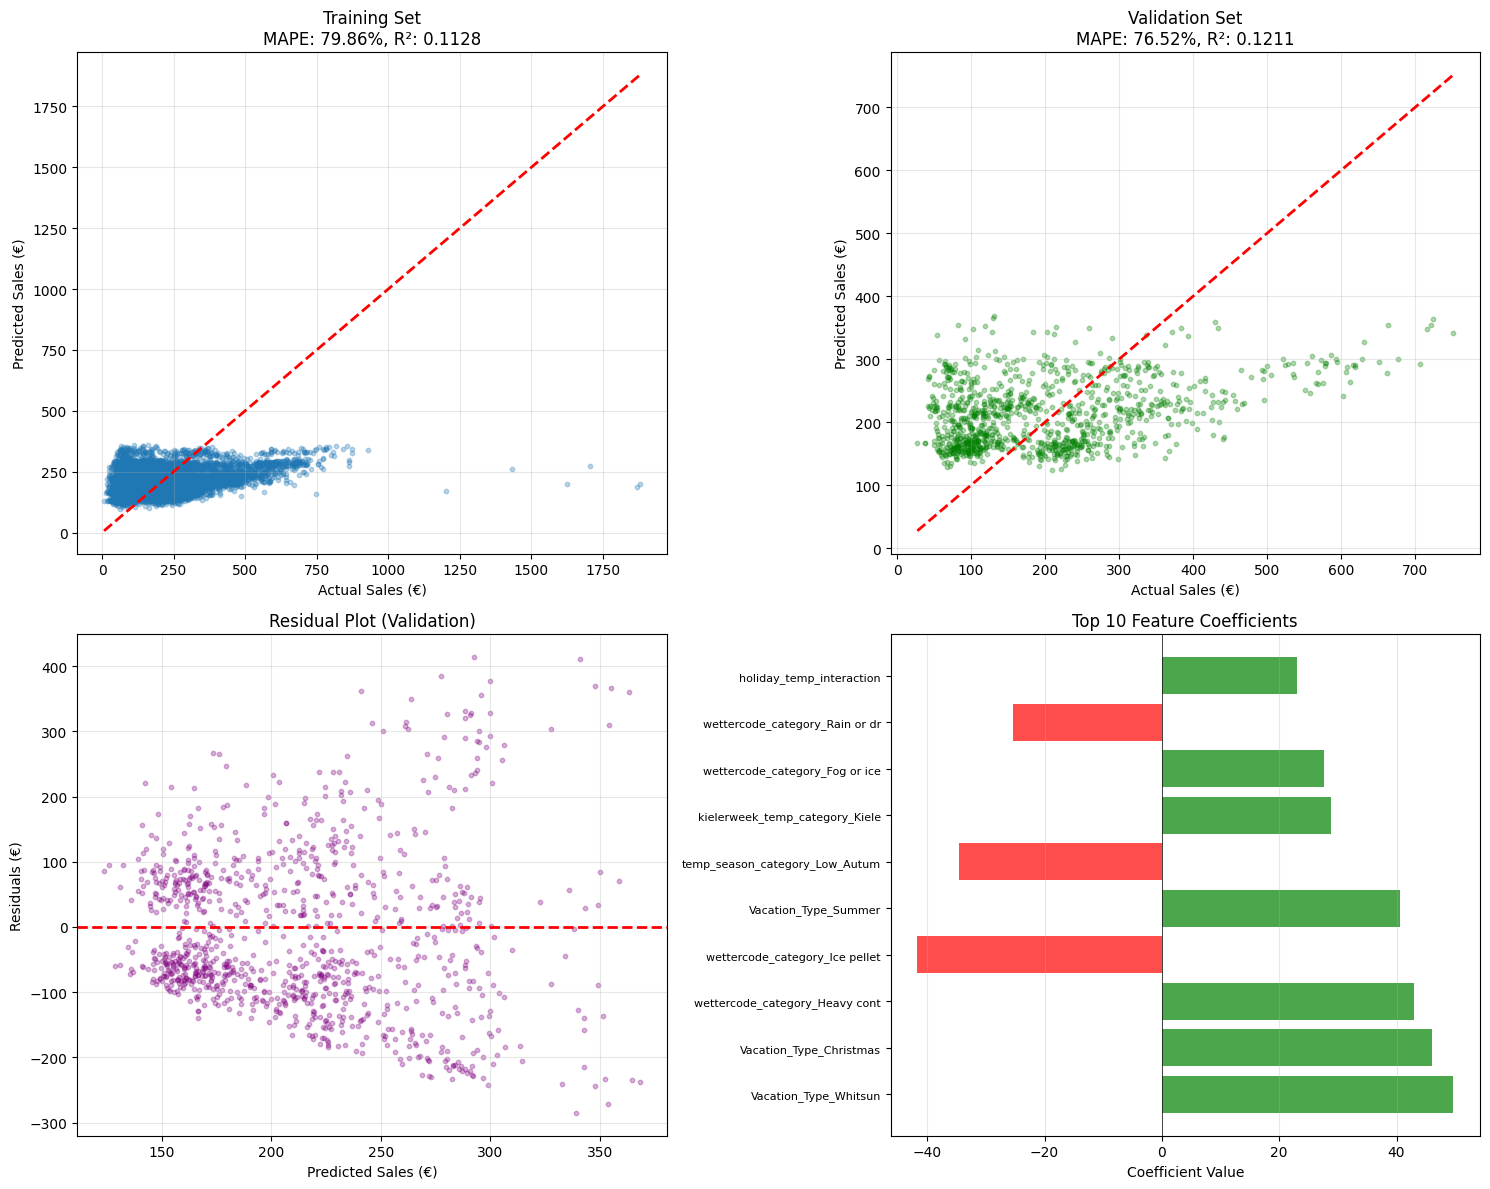

✓ Visualizations saved as 'baseline_model_results.png'


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted (Training)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.3, s=10)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales (€)')
axes[0, 0].set_ylabel('Predicted Sales (€)')
axes[0, 0].set_title(f'Training Set\nMAPE: {train_mape:.2f}%, R²: {train_r2:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Validation)
axes[0, 1].scatter(y_val, y_val_pred, alpha=0.3, s=10, color='green')
axes[0, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Sales (€)')
axes[0, 1].set_ylabel('Predicted Sales (€)')
axes[0, 1].set_title(f'Validation Set\nMAPE: {val_mape:.2f}%, R²: {val_r2:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals
residuals = y_val - y_val_pred
axes[1, 0].scatter(y_val_pred, residuals, alpha=0.3, s=10, color='purple')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Sales (€)')
axes[1, 0].set_ylabel('Residuals (€)')
axes[1, 0].set_title('Residual Plot (Validation)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Top 10 features
top_features = feature_importance.head(10)
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
axes[1, 1].barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels([f[:30] for f in top_features['Feature']], fontsize=8)
axes[1, 1].set_xlabel('Coefficient Value')
axes[1, 1].set_title('Top 10 Feature Coefficients')
axes[1, 1].axvline(x=0, color='black', linestyle='-', lw=0.5)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'baseline_model_results.png'")

---
## 11. Generate Predictions for Test Set

In [ ]:
print("Generating predictions for test set...\n")

# Make predictions
test_predictions = lr_model.predict(X_test)

# Create submission file
submission = test_encoded[['date', 'Warengruppe']].copy()
submission['umsatz_predicted'] = test_predictions
submission = submission.sort_values(['date', 'Warengruppe']).reset_index(drop=True)

print(f"Test Set Predictions:")
print(f"  Total predictions: {len(submission):,}")
print(f"  Mean predicted sales: €{submission['umsatz_predicted'].mean():.2f}")
print(f"  Date range: {submission['date'].min().date()} to {submission['date'].max().date()}")

print(f"\nFirst 10 predictions:")
print(submission.head(10))

# Save
submission.to_csv('baseline_predictions.csv', index=False)
print(f"\n✓ Saved to: baseline_predictions.csv")

Generating predictions for test set...

Test Set Predictions:
  Total predictions: 1,830
  Mean predicted sales: €208.78
  Date range: 2018-08-01 to 2019-07-30

First 10 predictions:
        date  Warengruppe  umsatz_predicted
0 2018-08-01          1.0        296.854559
1 2018-08-01          2.0        283.072925
2 2018-08-01          3.0        278.299072
3 2018-08-01          4.0        269.235650
4 2018-08-01          5.0        264.461798
5 2018-08-02          1.0        284.471868
6 2018-08-02          2.0        282.600855
7 2018-08-02          3.0        277.827003
8 2018-08-02          4.0        274.435503
9 2018-08-02          5.0        269.661651

✓ Saved to: baseline_predictions.csv


---
## 12. Summary

In [ ]:
print("="*80)
print("BASELINE MODEL - SUMMARY")
print("="*80)

print(f"\n📊 MODEL: Linear Regression")
print(f"   Features: {len(feature_cols)}")
print(f"   Training samples: {len(X_train):,}")

print(f"\n📈 PERFORMANCE (Validation Set):")
print(f"   MAPE: {val_mape:.2f}%")
print(f"   R²: {val_r2:.4f}")
print(f"   Adjusted R²: {val_adj_r2:.4f}")
print(f"   MAE: €{val_mae:.2f}")

print(f"\n✅ OUTPUTS:")
print(f"   ✓ baseline_predictions.csv - Test predictions")
print(f"   ✓ baseline_model_results.png - Visualizations")

print(f"\n📝 INTERPRETATION:")
print(f"   The baseline model explains {val_r2*100:.1f}% of variance in sales.")
print(f"   Average prediction error is {val_mape:.1f}%.")
print(f"   This provides a solid reference point for advanced models.")

print(f"\n" + "="*80)
print(f"✅ BASELINE MODEL COMPLETE!")
print(f"="*80)

BASELINE MODEL - SUMMARY

📊 MODEL: Linear Regression
   Features: 117
   Training samples: 8,294

📈 PERFORMANCE (Validation Set):
   MAPE: 76.52%
   R²: 0.1211
   Adjusted R²: 0.0095
   MAE: €100.18

✅ OUTPUTS:
   ✓ baseline_predictions.csv - Test predictions
   ✓ baseline_model_results.png - Visualizations

📝 INTERPRETATION:
   The baseline model explains 12.1% of variance in sales.
   Average prediction error is 76.5%.
   This provides a solid reference point for advanced models.

✅ BASELINE MODEL COMPLETE!
